In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from matplotlib.animation import FuncAnimation


def create_gaussian_wavepacket(x, x0, k0, sigma):
    psi = np.exp(-(x - x0)**2 / (2 * sigma**2)) * np.exp(1j * k0 * x)
    dx = x[1] - x[0]
    return psi / np.sqrt(np.sum(np.abs(psi)**2) * dx)


def build_crank_nicolson_operators(x, V, dt):
    N = len(x)
    dx = x[1] - x[0]
    coeff = -0.5 / dx**2
    
    main_diag = -2 * coeff * np.ones(N) + V
    off_diag = coeff * np.ones(N - 1)
    
    H = diags([main_diag, off_diag, off_diag], [0, -1, 1])
    I = diags([np.ones(N)], [0])
    
    lhs = (I + 1j * (dt / 2) * H).tocsc()
    rhs = I - 1j * (dt / 2) * H
    return lhs, rhs


def run_basic_simulation(L, N, dt, t_max, V, psi, title, filename, 
                         ylim=(-0.5, 1.5), scale_prob=3.0, scale_real=1.0, 
                         boundary_condition=None):
    x = np.linspace(0, L, N)
    steps = int(t_max / dt)
    lhs_mat, rhs_mat = build_crank_nicolson_operators(x, V, dt)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlim(0, L)
    ax.set_ylim(*ylim)
    
    line_prob, = ax.plot([], [], 'k-', lw=2, label=r'$|\psi(x)|^2$')
    line_real, = ax.plot([], [], 'b--', lw=1, alpha=0.5, label=r'$Re(\psi)$')
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
    
    if boundary_condition == 'infinite_well':
        ax.axvline(0, color='r', linewidth=4, alpha=0.5)
        ax.axvline(L, color='r', linewidth=4, alpha=0.5, label='Infinite Walls')
    elif V is not None and np.any(V != 0):
        ax.plot(x, V, 'r-', lw=2, alpha=0.3, label='Potential V(x)')
    
    ax.set_xlabel('Position (x)')
    ax.set_ylabel('Probability Density')
    ax.set_title(title)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    psi_state = {'psi': psi.copy()}
    
    def update(frame):
        psi_state['psi'] = spsolve(lhs_mat, rhs_mat.dot(psi_state['psi']))
        if boundary_condition == 'infinite_well':
            psi_state['psi'][0] = 0
            psi_state['psi'][-1] = 0
        
        line_prob.set_data(x, np.abs(psi_state['psi'])**2 * scale_prob)
        line_real.set_data(x, psi_state['psi'].real * scale_real)
        time_text.set_text(f'Time = {frame * dt:.1f}')
        return line_prob, line_real, time_text
    
    anim = FuncAnimation(fig, update, frames=range(0, steps, 5), interval=30, blit=True)
    anim.save(filename, fps=30)
    plt.show()

* **Infinite Potential Well**

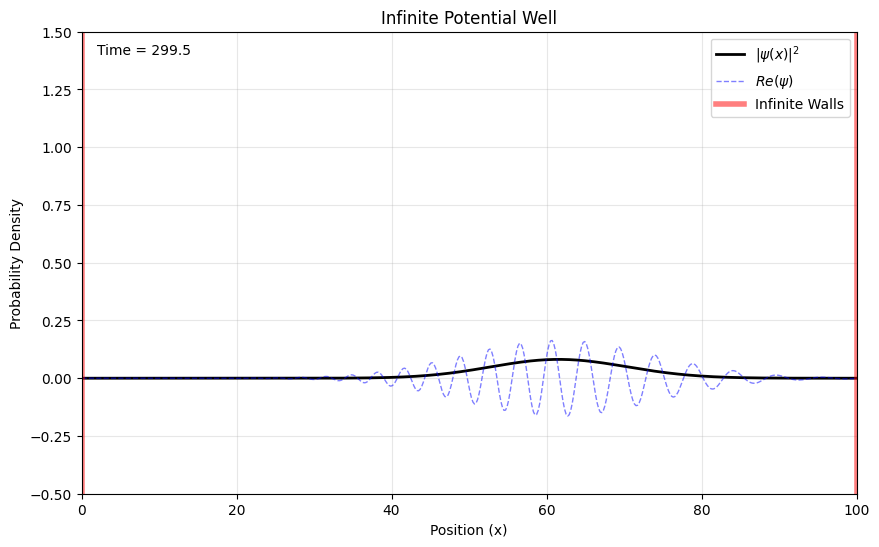

In [5]:
L, N, dt, t_max = 100.0, 500, 0.1, 300
x = np.linspace(0, L, N)
V = np.zeros(N)

psi = create_gaussian_wavepacket(x, x0=L/2, k0=1.5, sigma=5.0)
psi[0] = psi[-1] = 0

run_basic_simulation(
    L, N, dt, t_max, V, psi,
    title='Infinite Potential Well',
    filename='../simulation/infinite_well_potential.mp4',
    ylim=(-0.5, 1.5), scale_prob=3.0, scale_real=1.0,
    boundary_condition='infinite_well'
)

* **Finite Potential Well**





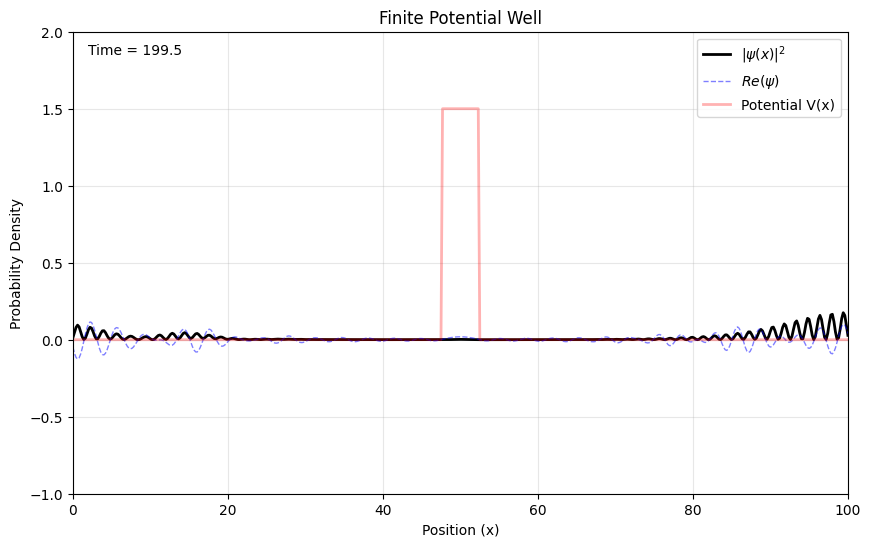

In [6]:
L, N, dt, t_max = 100.0, 500, 0.1, 200
x = np.linspace(0, L, N)

V0, w, center = 1.5, 5.0, L / 2
V = np.zeros(N)
V[np.abs(x - center) < w / 2] = V0

psi = create_gaussian_wavepacket(x, x0=L/4, k0=2.0, sigma=3.0)

run_basic_simulation(
    L, N, dt, t_max, V, psi,
    title='Finite Potential Well',
    filename='../simulation/finite_wall_potential.mp4',
    ylim=(-1, 2.0), scale_prob=1.5, scale_real=0.5
)